In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import pickle, gzip
import gc
import time

In [2]:
train_series = pd.read_csv('training_set.csv')
metadata_train = pd.read_csv('training_set_metadata.csv')

simple_features = train_series.groupby(
    ['object_id', 'passband'])['flux'].agg(
    ['mean', 'median', 'max', 'min', 'std']).unstack('passband')


#construct time series using binned observations:
ts_mod = train_series[['object_id', 'mjd', 'passband', 'flux']].copy()
#bin by 5 days, reducing the size of data but still giving a time series
ts_mod['mjd_d5'] = (ts_mod['mjd'] / 5).astype(int)
ts_mod = ts_mod.groupby(['object_id', 'mjd_d5', 'passband'])['flux'].mean().reset_index()

#pivotting
ts_piv = pd.pivot_table(ts_mod, 
                        index='object_id', 
                        columns=['mjd_d5', 'passband'], 
                        values=['flux'],
                        dropna=False)

gc.enable()

In [3]:
del metadata_train['ra'],metadata_train['decl'],metadata_train['gal_l'], metadata_train['gal_b'],metadata_train['hostgal_photoz'],metadata_train['hostgal_photoz_err'], metadata_train['distmod'], metadata_train['mwebv']
#Bin into ddf and non-ddf training
ddf = metadata_train[(metadata_train['ddf'] == 1)]
del ddf['ddf']

ddf_far_away= (ddf[(ddf['hostgal_specz'] > 0)])
ddf_far_away.set_index('object_id', inplace=True)
ddf_nearby= ddf[(ddf['hostgal_specz'] <=0)]
ddf_nearby.set_index('object_id', inplace=True)
non_ddf = metadata_train[(metadata_train['ddf'] == 0)]
del non_ddf['ddf']

non_ddf_far_away= non_ddf[(non_ddf['hostgal_specz'] >0)]
non_ddf_far_away.set_index('object_id', inplace=True)
non_ddf_nearby= non_ddf[(non_ddf['hostgal_specz'] <=0 )]
non_ddf_nearby.set_index('object_id', inplace=True)
del ddf, non_ddf, ddf_far_away['hostgal_specz'], non_ddf_far_away['hostgal_specz'], ddf_nearby['hostgal_specz'], non_ddf_nearby['hostgal_specz']

gc.collect()

bins = [ddf_far_away, ddf_nearby, non_ddf_far_away, non_ddf_nearby]

In [4]:
def get_data_point(object_id, bin_name):
    x = torch.tensor(ts_piv.loc[object_id].values.reshape(-1, 1, 6), dtype = torch.float32)
    x[x != x] = 0
    y = torch.tensor([classes.index(bin_name.loc[object_id].target)])
    return x, y

def random_data_point(bin_name):
    object_id = bin_name.sample().index.values[0]
    return get_data_point(object_id, bin_name)

In [5]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size=1):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_size
        self.batch_size = batch_size
        #TODO add dropout or something
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2)
        self.hidden2out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.hidden = self.init_hidden()
    
    def forward(self, sequence):
        x = sequence.view(len(sequence), self.batch_size , -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        output  = self.hidden2out(lstm_out[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return (torch.zeros(2, self.batch_size, self.hidden_dim),
                torch.zeros(2, self.batch_size, self.hidden_dim))

In [7]:
classes = tuple(metadata_train.target.unique())

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return classes[category_i], category_i

In [9]:
def predict(model, bin_name, sample=1):
    
    vc = bin_name.target.value_counts(normalize=True)
    weights = torch.tensor([1-(vc.loc[i]) if i in vc.index else 1 for i in classes])
    
    labels = []
    loss = 0
    criterion = nn.NLLLoss(weight=weights)
    s = bin_name.sample(frac=sample)
    with torch.no_grad():
        for obj_id in s.index:
            x, y = get_data_point(obj_id, s)
            y_hat = model(x)
            label = categoryFromOutput(y_hat)[0]
            labels.append([obj_id, label, bin_name.loc[obj_id].target])
            loss += criterion(y_hat, y)

    print("Average Weighted Loss: {:.2f}".format(loss/len(s)))
    labels= pd.DataFrame(labels, columns=["object_id", "y_pred", "y_true"])
    labels.set_index("object_id", inplace=True)
    return labels, loss/len(s)

In [10]:
def up_sample(bin_name, n=None):
    from sklearn.utils import resample
    classes = bin_name.target.unique()
    class_dfs = [bin_name[bin_name.target == class_] for class_ in classes]
    if not n:
        n = np.max([len(df) for df in class_dfs])
    even_dfs = [resample(df,
                        replace=True,
                        n_samples=n) for df in class_dfs]
    return pd.concat(even_dfs).sample(frac=1).reset_index()

In [12]:
def train(train_bin_name, valid_bin_name, n_samples=None, epochs=1, verbose=True):
    
    # Initialize Model
    print("Building LSTM model..")
    model = RNN(6, 32, 14)
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = .9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=verbose) #epochs//10-1
    print("Done.")
    print_every = 500
    current_loss = 0
    
    train_loss = []
    valid_loss = []
    min_loss = np.inf

    start_t = time.time()
    
    for epoch in range(epochs):
        randomized_bin = up_sample(train_bin_name, n=n_samples)
        n = len(randomized_bin)
        for i, row in randomized_bin.iterrows():
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            
            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            model.hidden = model.init_hidden()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of light curve inputs.
            obj_id = row['object_id']
            x_train, y_train = get_data_point(obj_id, train_bin_name)

            # Step 3. Run our forward pass.
            y_hat = model(x_train)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = criterion(y_hat, y_train)
            current_loss += loss
            loss.backward()
            optimizer.step()
            
            if ((i+1)%print_every == 0 and verbose):
                print("Epoch {} {:.0f}% ===> Avg Loss: {:.3f}".format(epoch, (i/n*100), current_loss/print_every))
                current_loss=0
                
        # After each epoch test on validation data
        print("Epoch {}: Validation".format(epoch), end =" ")
        _, vloss = predict(model, valid_bin_name)
        _, tloss = predict(model, train_bin_name)
        valid_loss.append(vloss)
        train_loss.append(tloss)
        
        # Give it to the scheduler to see if learning rate needs to be reduced
        scheduler.step(vloss)
        
        if vloss < min_loss:
            min_loss = vloss
            print(f"         Model achieved record validation loss, Saving to {start_t}_E{epoch}_L{vloss}.pt")
            torch.save(model.state_dict(), f'models/{start_t}_E{epoch}.pt')
            print("         Done.")
            
    print(f"Finished {epochs} epochs in {time.time() - start_t}")
    return model, valid_loss, train_loss

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import warnings

In [14]:
# Split into validation and training.
ddf_far_away_train, ddf_far_away_validation = train_test_split(ddf_far_away, test_size=0.2)
ddf_nearby_train, ddf_nearby_validation = train_test_split(ddf_nearby, test_size=0.2)
    
non_ddf_far_away_train, non_ddf_far_away_validation = train_test_split(non_ddf_far_away, test_size=0.2)
non_ddf_nearby_train, non_ddf_nearby_validation = train_test_split(non_ddf_nearby, test_size=0.2)
    
# Bin up
training_bin = [ddf_far_away_train, ddf_nearby_train, 
                non_ddf_far_away_train, non_ddf_nearby_train]

validation_bin = [ddf_far_away_validation, ddf_nearby_validation, 
                   non_ddf_far_away_validation, non_ddf_nearby_validation]

# filenames = ['ddf_far_away', 'ddf_nearby', 'non_ddf_far_away', 'non_ddf_nearby']


In [16]:
model = train(ddf_nearby_train, ddf_nearby_validation, epochs=50)

Building LSTM model..
Done.
Epoch 0 41% ===> Avg Loss: 1.796
Epoch 0 82% ===> Avg Loss: 1.545
Epoch 0: Validation Average Weighted Loss: 1.67
Average Weighted Loss: 1.62
         Model achieved record validation loss, Saving to 1544080538.7591035_E0_L1.6659218072891235.pt
         Done.
Epoch 1 41% ===> Avg Loss: 1.812
Epoch 1 82% ===> Avg Loss: 1.110
Epoch 1: Validation Average Weighted Loss: 1.23
Average Weighted Loss: 1.19
         Model achieved record validation loss, Saving to 1544080538.7591035_E1_L1.226354956626892.pt
         Done.
Epoch 2 41% ===> Avg Loss: 1.686
Epoch 2 82% ===> Avg Loss: 0.942
Epoch 2: Validation Average Weighted Loss: 1.92
Average Weighted Loss: 1.69
Epoch 3 41% ===> Avg Loss: 0.880
Epoch 3 82% ===> Avg Loss: 0.978
Epoch 3: Validation Average Weighted Loss: 1.39
Average Weighted Loss: 1.34
Epoch 4 41% ===> Avg Loss: 1.085
Epoch 4 82% ===> Avg Loss: 0.608
Epoch 4: Validation Average Weighted Loss: 1.00
Average Weighted Loss: 1.00
         Model achieved rec

In [19]:
#model = RNN(6, 32, 14)
#model.load_state_dict(torch.load("models/1544050544.596692_E0.pt"))
#model.eval()
y_hat, loss = predict(model[0], ddf_nearby_validation)

Average Weighted Loss: 4.30


In [25]:
def confusion(labels, plot=True):
    classes = np.sort(list(labels.y_true.unique()))
    y_pred = np.array(labels.y_pred)
    y_true = np.array(labels.y_true)
    cm=confusion_matrix(y_true, y_pred)
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(9,9))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, cmap='inferno', annot=True, lw=1, fmt=".2f")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    if plot:
        plt.show()

def plot_accuracy(train_loss, valid_loss):
    fig_nodes = plt.figure(figsize=(8,8))
    ax1 = fig_nodes.add_subplot(1,1,1)
    ax1.plot(train_loss, marker='o', markersize=5, label = "Training")
    ax1.plot(valid_loss, marker='+', markersize=5, label = "Validation")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title(f"Training Loss wrt Epochs")
    plt.legend()
    plt.show()

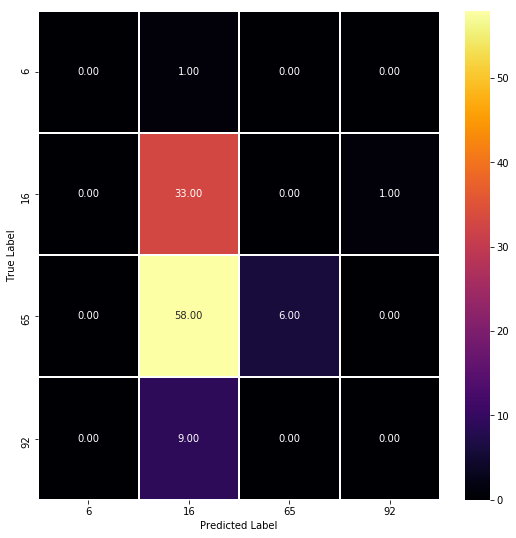

In [21]:
confusion(y_hat)

In [87]:
len(up_sample(ddf_far_away_train))

6831

In [91]:
up_sample(ddf_far_away_train)["target"].value_counts()

95    759
67    759
15    759
90    759
62    759
42    759
88    759
64    759
52    759
Name: target, dtype: int64

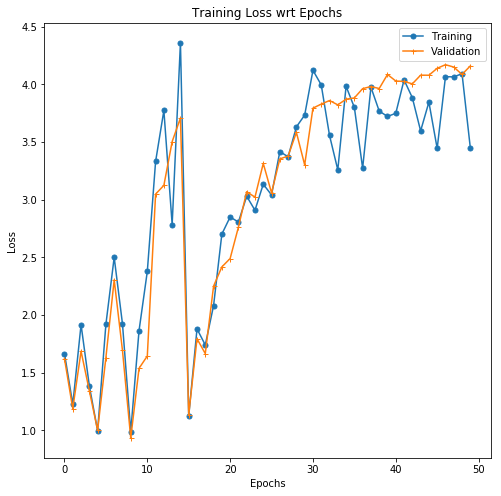

In [26]:
plot_accuracy(model[1], model[2])